In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import scipy.io as sio
import copy
import pylab as pl
import time
from IPython import display

## Chirp parameters

In [2]:
start_freq = 770000
band_freq_small = 50000
band_freq_greate = 160000
duration = 0.0004
samples_one_second = 10000000
rate = samples_one_second / start_freq
sample = start_freq * rate
npnts = int(sample * duration)
print("Smpale per cicle", rate, "Sample for one second", samples_one_second, "Total semples", npnts)

Smpale per cicle 12.987012987012987 Sample for one second 10000000 Total semples 4000


In [17]:
def chirp_gen(duration, npnts, start_freq, band_freq):
    timevec = np.linspace(0, duration, npnts)
    chirp = signal.chirp(timevec,f0=start_freq,t1=duration,f1=start_freq + band_freq)
    return chirp

def power_spectrum(signal,spectrum_val, npnts, lowx, highx, title='Power spectrum'):
    hz = np.linspace(0, spectrum_val / 2, int(np.floor(npnts / 2) + 1))
    spectrum = 2*np.abs(scipy.fftpack.fft(signal)) / npnts
    plt.figure(figsize=(16,4))
    plt.stem(hz,spectrum[0:len(hz)])
    plt.xlim([lowx, highx])
    plt.title(title)
    plt.show()   
    
def two_objects_detector(chirp, shift1, shift2, band_freq, distance_per_herz, title=''):
    # local synthesizer
    tx = chirp[shift1 + shift2:]
    # First object reflection signal
    rx1 = chirp[:-(shift1 + shift2)]
    # Second object reflection signal
    rx2 = chirp[shift2:-shift1]

    # mixing all frequencies
    mix = tx * rx2 + rx1 * rx2# + tx * rx2

#     plt.figure(figsize=(16,3))
#     plt.plot(timevec[:-(shift1 + shift2)], mix)
#     plt.title("Time domain mix shift chirp " + title)
#     plt.show()

    accuracy = int(npnts * 10)

    hz = np.linspace(0, sample / 2, int(np.floor(accuracy / 2) + 1))

    fftmix = scipy.fftpack.fft(mix, n=accuracy)
    ifSpectrum = np.abs(fftmix) / accuracy
    ifSpectrum[1:] = ifSpectrum[1:] * 2

    # Find local high as detection
    hz_band_freq = hz[hz <= band_freq]
    testIifSpectrum = ifSpectrum[:len(hz_band_freq)]
    localMax = np.squeeze(np.where( np.diff(np.sign(np.diff(testIifSpectrum))) < 0)[0]) + 1

    meanMax = testIifSpectrum[localMax].mean()
    maxSpectrum = testIifSpectrum[localMax].max()
    trigger = maxSpectrum * .8

    valid_local_indexs = localMax[testIifSpectrum[localMax] > trigger]

    colors = ['r','g','c','m','y']

    plt.figure(figsize=(16,3))
    plt.plot(hz_band_freq, testIifSpectrum,'b-o',  label='spectrum')

    # Convert chirp shift to distance
    dist = smallest_measure_distance * shift1
    # Convert distance to frequency
    scale = dist / distance_per_herz
    plt.plot([scale,scale], [maxSpectrum, 0],'g--',  label='closest distance1 {}'.format(np.round(dist,3)))

    # Convert chirp shift to distance
    dist = smallest_measure_distance * shift2
    # Convert distance to frequency
    scale = dist / distance_per_herz
    plt.plot([scale,scale], [maxSpectrum, 0],'y--',  label='closest distance2 {}'.format(np.round(dist,3)))


    plt.plot([hz_band_freq[0],hz_band_freq[-1]],[trigger,trigger],'--',label='trigger level {}'.format(np.round(trigger,3)))
    for i in range(len(valid_local_indexs)):
        pos = valid_local_indexs[i]
        freq = hz_band_freq[pos]
        spect_val = testIifSpectrum[pos]
        plt.plot(freq, spect_val,colors[i % len(colors)] + 'o', 
                 label='detection frq {} distance {}'.format(freq, np.round(freq * distance_per_herz, 2)))

    plt.xlim([0,hz[valid_local_indexs[-1]] * 2])
    plt.title("Friquncy domain IF signal " + title)
    plt.legend()
    plt.show()
    
    return mix
    

## Create the chirps

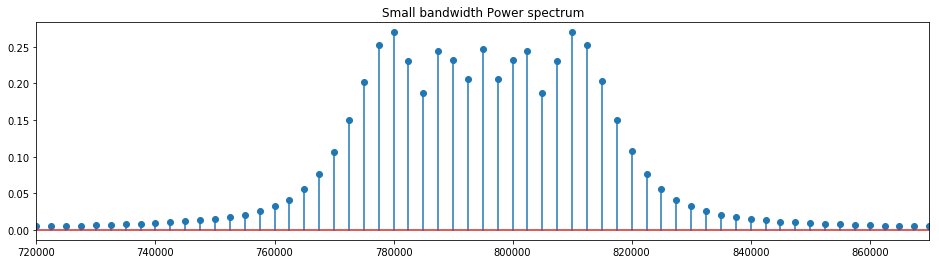

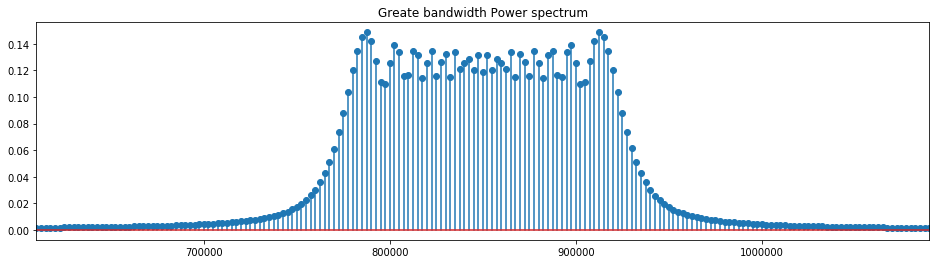

In [18]:
chirp_small = chirp_gen(duration,npnts,start_freq, band_freq_small)
chirp_greate = chirp_gen(duration,npnts,start_freq, band_freq_greate)
power_spectrum(chirp_small,sample,npnts,start_freq - band_freq_small,start_freq + band_freq_small * 2,'Small bandwidth Power spectrum')
power_spectrum(chirp_greate,sample,npnts,start_freq - band_freq_greate,start_freq + band_freq_greate * 2,'Greate bandwidth Power spectrum')

# Distance of an objects in km

In [19]:
kilometer = 12
kilometer2 = 16

# RX TX Chirp Mix of 2 object

In [20]:
light_speed_km = 300000
print('Theoretical max distance of a chirp of', light_speed_km * duration / 2, 'km')
smallest_measure_distance = light_speed_km * (1 / samples_one_second) / 2
print('smallest measure distance',smallest_measure_distance, 'km\n')

shift = int((1 / smallest_measure_distance) * kilometer)
distance_per_herz_small = (light_speed_km * duration / 2) / band_freq_small
print('Friquncy domain per distance', distance_per_herz_small, 'km per herz, for bandwidth of',band_freq_small)

print('shift', shift, 'out of', npnts, 'sample points, for a distance of', np.round(shift * smallest_measure_distance, 3), 'km')
print()

shift2 = int((1 / smallest_measure_distance) * kilometer2)
print('shift2', shift2, 'out of', npnts, 'sample points, for a distance of', np.round(shift2 * smallest_measure_distance, 3), 'km')

distance_per_herz_grate = (light_speed_km * duration / 2) / band_freq_greate
print('Friquncy domain per distance', distance_per_herz_grate, 'km per herz, for bandwidth of',band_freq_greate)
print()

Theoretical max distance of a chirp of 60.0 km
smallest measure distance 0.015 km

Friquncy domain per distance 0.0012 km per herz, for bandwidth of 50000
shift 800 out of 4000 sample points, for a distance of 12.0 km

shift2 1066 out of 4000 sample points, for a distance of 15.99 km
Friquncy domain per distance 0.000375 km per herz, for bandwidth of 160000



## Try to resolve object distance

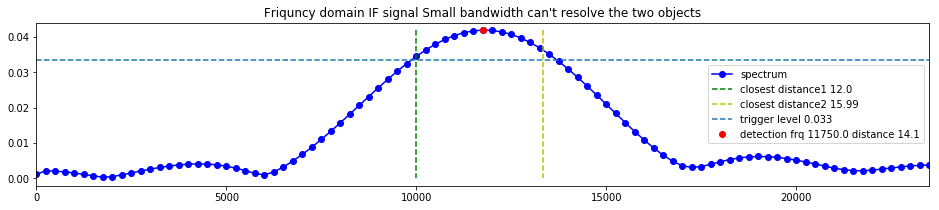

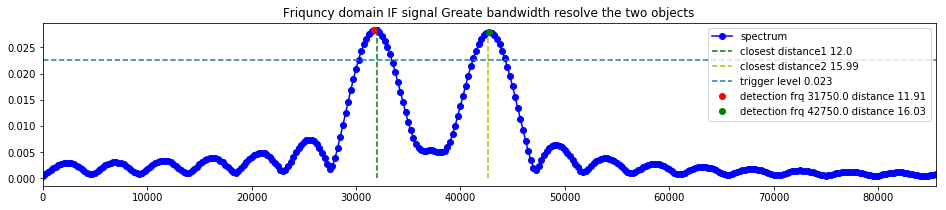

In [21]:
mix_small = two_objects_detector(chirp_small,shift,shift2, band_freq_small, distance_per_herz_small, 
                                 "Small bandwidth can't resolve the two objects")
mix_greate = two_objects_detector(chirp_greate,shift,shift2, band_freq_greate, distance_per_herz_grate, 
                                  'Greate bandwidth resolve the two objects')